In [ ]:
pip install -U kaleido

### **Importing modules**

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import plotly
import plotly.graph_objs as go
import plotly.express as px
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay,confusion_matrix, classification_report,accuracy_score, f1_score

import random
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, Reshape, MaxPool2D,BatchNormalization,GlobalAveragePooling2D

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

In [2]:
import warnings
warnings.filterwarnings('ignore')

### **Directory Hierarchy:**

- fire-risk-classifier

 
  - Train/

    - High

    - Low

    - Moderate
    
    - Non-burnable
    
    - Very-high
    
    - Very-low
    
    - Water

  - Validation/
    
    - High

    - Low

    - Moderate
    
    - Non-burnable
    
    - Very-high
    
    - Very-low
    
    - Water

### **Visualization of labels**



Based on the distribution it is evident that the dataset is uniformly balanced accross multiple classes.

In [3]:
# Paths to training and testing datasets

train_data_path = "/kaggle/input/fire-risk-classification/train/"
test_data_path = "/kaggle/input/fire-risk-classification/val/"


# Class labels
labels = ["High", "Low", "Moderate", "Non-burnable", "Very_High", "Very_Low", "Water"]


# Count the number of images in each folder for training and testing
train_counts = [len(os.listdir(train_data_path + i)) for i in labels]
test_counts = [len(os.listdir(test_data_path + i)) for i in labels]

# Create the bar plot using Plotly
fig = go.Figure()

# Add bars for training data
fig.add_trace(go.Bar(
    x=labels, 
    y=train_counts, 
    name='Train',
    marker_color='purple'

))

# Add bars for testing data
fig.add_trace(go.Bar(
    x=labels, 
    y=test_counts, 
    name='Test',
    marker_color='green'
))


# Add labels and title
fig.update_layout(
    title='Distribution of Labels in Training and Testing Data',
    xaxis_title='Classes',
    yaxis_title='Count',
    barmode='group'  
)

# Show plot
fig.show()

In [4]:
print("Total number of samples in the training dataset : ", sum(train_counts))
print("Total number of samples in the test dataset : ", sum(test_counts))

Total number of samples in the training dataset :  7000
Total number of samples in the test dataset :  700


### **Dataset Visualization**

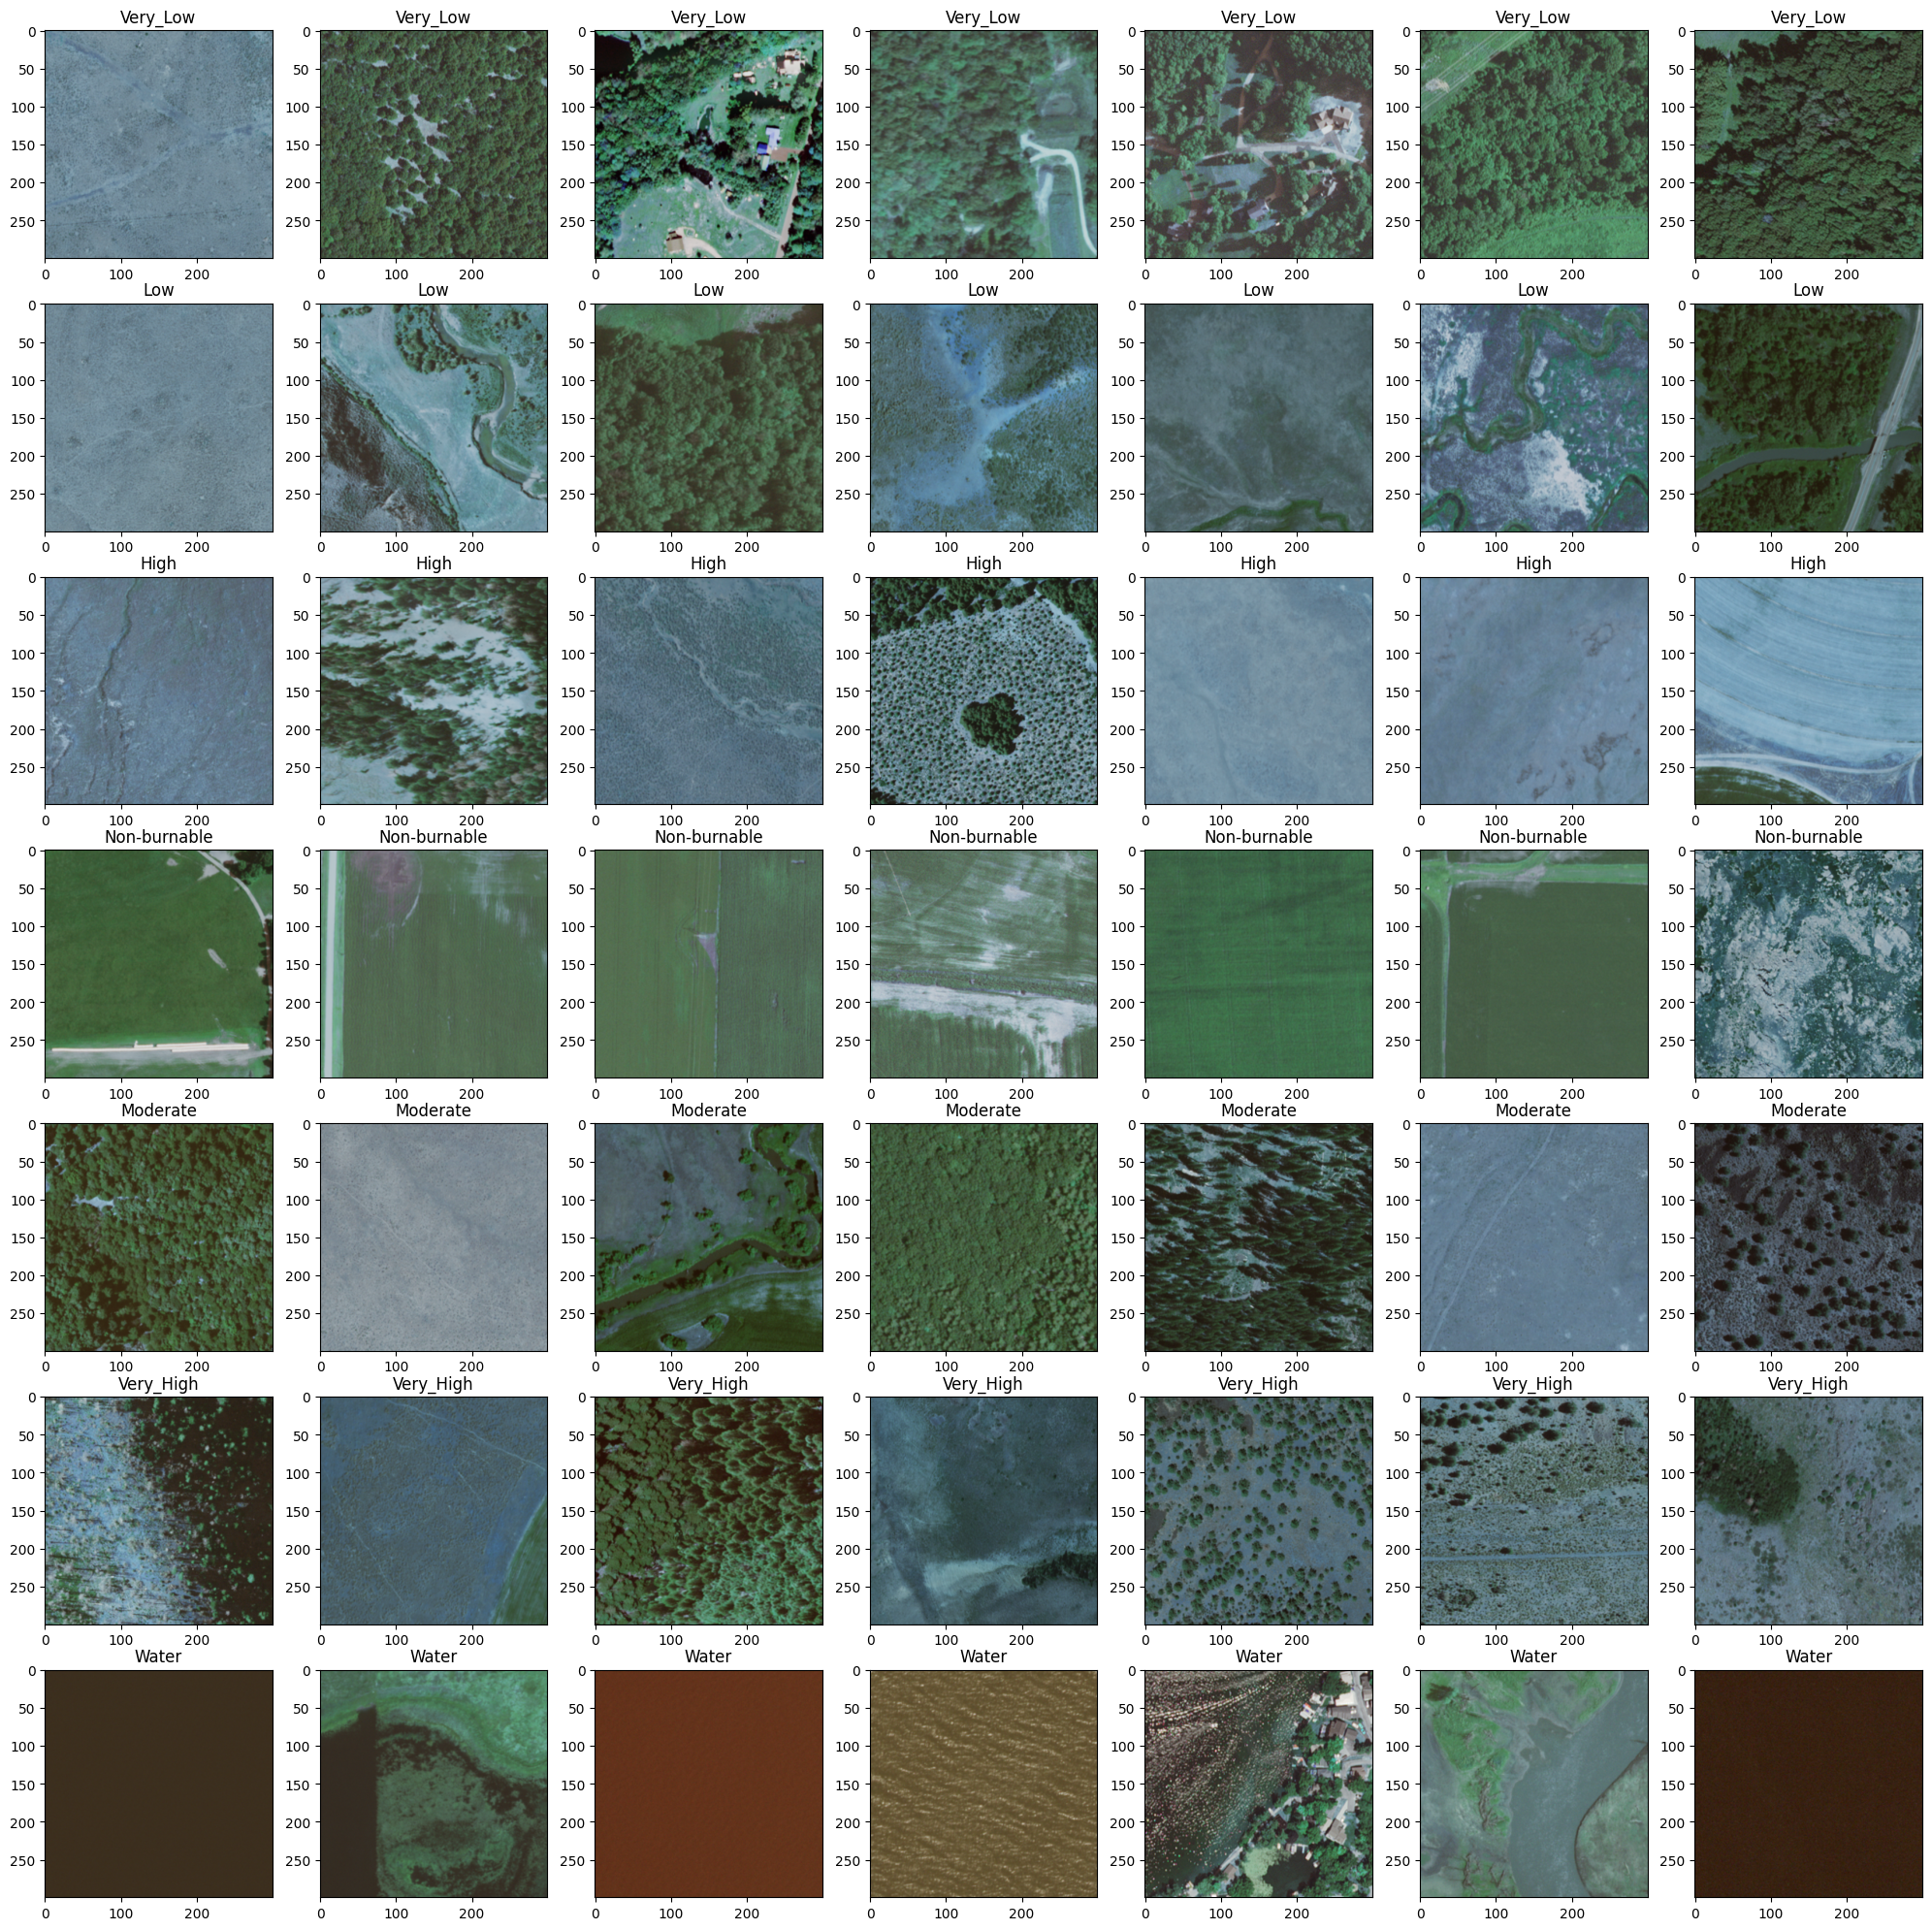

In [7]:
src_path = "/kaggle/input/fire-risk-classification/train"

sub_class = os.listdir(src_path)

fig = plt.figure(figsize=(25,25))

count=1
for label in range(len(sub_class)):
    path = os.path.join(src_path,sub_class[label]) #reading the images from the dataset
    img = os.listdir(path)

    for i in img[:7]:
        plt.subplot(7,7,count)
        image = Image.open(path+"/"+i)
        image = image.resize((300,300)) #reshape the image to 300x300
        plt.imshow(image)
        plt.title(sub_class[label])
        count+=1

### **Model Training function**

In [9]:
def train_model(model, train_generator, validation_generator, epochs, name):

    """
    Trains a neural network model using the provided data generators.

    Parameters:
    - `model` (keras.Model): The neural network model to be trained.
    - `train_generator` (keras.utils.data.DataGenerator): The data generator for training data.
    - `validation_generator` (keras.utils.data.DataGenerator): The data generator for validation data.
    - `epochs` (int): The number of training epochs.
    - `name` (str): The name used for saving model weights.

    Returns:
    - `history` (keras.callbacks.History): The training history containing loss and metric values.

    """

    # Define the path for saving model weights
    path_cp = name + 'ac_model.keras'


    # Reduce learning rate when validation loss plateaus
    rlr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=4,
        verbose=1,
        min_delta=1e-4,
        min_lr=1e-5,
        mode='min',
        cooldown=1
    )


    # Save the model weights with the lowest validation loss
    ckp = ModelCheckpoint(
        path_cp,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )

    # Early stopping to prevent overfitting by monitoring validation loss
    es = EarlyStopping(
        monitor='val_loss',
        min_delta=1e-4,
        patience=8,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )


    # Fit the neural network model using the provided data generators
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        verbose=1,
        callbacks=[rlr, es, ckp]
    )


    return history


## **Data preprocessing and Image Augmentation**



This code snippet is responsible for setting up data generators for training and validation datasets used in a machine learning model for image classification. Here's a bit more detail:



1. **Image Data Augmentation**: The code uses an `ImageDataGenerator` to apply various transformations to the images, such as rotation, shearing, zooming, shifting, adjusting brightness, and horizontal flipping. These augmentations create variations of the original images, which helps the model generalize better during training.



2. **Training Data Generator Setup**:

   - `train_generator` is created using `flow_from_directory` to process and augment images from the training dataset directory.

   - The `directory` parameter specifies the location of the training images.

   - `target_size` resizes the images to a standard size of 224x224 pixels.

   - `color_mode` is set to RGB.

   - `class_mode` indicates that this is a multi-class classification problem.

   - `batch_size` determines the number of images processed in each training batch.

   - `subset='training'` specifies that this generator is for the training data.



3. **Validatio Data Generator Setup**:

   - `validation_generator` is set up similarly to the training generator but for the validation dataset.

   - The key difference is `shuffle=False`, ensuring that the validation data remains in a consistent order during evaluation.



In summary, this code prepares data generators that apply data augmentation techniques to the training images and read both training and validation data. These generators are typically used to train a convolutional neural network (CNN) or similar models for image classification tasks. The augmentation helps improve the model's ability to recognize patterns in images and generalize to new, unseen data.

In [11]:
# Image data generator is used to increase the total number of samples in your dataset
# We increase the dataset by manipulating the image, and getting different variations for the image.
# It can include rotating the images, fliping the image, changing the brightness

train_generator = ImageDataGenerator(rescale=1./255,
                                      width_shift_range=0.3,
                                      height_shift_range=0.2,
                                      brightness_range=[0.4,1.5],
                                     horizontal_flip=True
                                    ) 


val_generator = ImageDataGenerator(rescale=1./255) 


train_generator = train_generator.flow_from_directory(
    directory="/kaggle/input/fire-risk-classification/train", #reading images from training dataset
    target_size=(224, 224), #making the image size 224, 224
    color_mode="rgb",
    class_mode='categorical', 
    batch_size = 64, #we do not send all the images at once to model, but send them in batches
    subset='training') # set as training data


validation_generator = val_generator.flow_from_directory(
    directory="/kaggle/input/fire-risk-classification/val", #reading images from vaidation dataset
    target_size=(224,224), #making the image size 224, 224
    color_mode="rgb",
    class_mode='categorical',
    batch_size = 64, # we do not send all the images at once to model, but send them in batches
    shuffle=False) # set as validation data #shuffle = false to be changed when training the model

Found 7000 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


### **Metric Evaluation**

In [27]:
def confusion_matrix_visual(y_test, y_pred_label):

    """
    This function plots the confusion matrix for given actual and predicted labels
    """
    
    targ_labels =["High", "Low", "Moderate", "Non-burnable", "Very_High", "Very_Low", "Water"]
    conf_matrix = confusion_matrix(y_test, y_pred_label)

    plt.figure(figsize=(10,8))
    fx=sns.heatmap(confusion_matrix(y_test,y_pred_label), annot=True, fmt=".2f", cmap="Blues")
    fx.set_title('Confusion Matrix \n')
    fx.set_xlabel('\n Predicted Values\n')
    fx.set_ylabel('Actual Values\n')
    fx.xaxis.set_ticklabels(targ_labels)
    fx.yaxis.set_ticklabels(targ_labels)

    plt.show()

In [14]:
def report_test(y_test, y_pred_label):
    """
    This function gives us the classification report for the predicted and actual labels
    """

    targ_labels =["High", "Low", "Moderate", "Non-burnable", "Very_High", "Very_Low", "Water"]
    class_report = classification_report(y_test, y_pred_label, target_names=targ_labels, output_dict=True)
    sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True, cmap='inferno')

In [16]:
def loss_accuracy_graph(history):
    """
    This function summarizes history for accuracy and loss. The graph shows the training and validation accuracy and loss over the epochs.
    """

    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### **Transfer learning**





Transfer learning is a machine learning technique where a model trained on one task is reused or fine-tuned for a different, but related, task. Instead of training a model from scratch, transfer learning allows leveraging pre-trained models (typically on large datasets like ImageNet) and adapting them to new tasks with fewer resources. It is especially useful when:

- You have limited data for the target task.

- The pre-trained model has learned general features that can be useful for the new task.



The key steps in transfer learning include:

1. **Choosing a pre-trained model**: Select a model trained on a large dataset.

2. **Freezing or unfreezing layers**: Decide which layers to freeze (i.e., keep their weights fixed) and which layers to fine-tune on the new data.

3. **Adding a new classifier**: Usually, the top layers (i.e., the fully connected layers) are replaced or retrained to adapt the model to the specific classes or task at hand.


mplicity and depth compared to earlier architectures.





### **ResNet50**



### ResNet-50 Architecture (Brief Overview):



ResNet-50 (Residual Network with 50 layers) is a deep convolutional neural network (CNN) that introduced **residual learning** to solve the problem of **vanishing gradients** in very deep networks. The key idea is to use **skip connections** (or residual connections) that bypass one or more layers, allowing the network to learn the identity mapping more easily and effectively.



#### Key Features of ResNet-50:



1. **Depth**: 

   - The architecture has **50 layers**, including convolutional layers, pooling layers, and fully connected layers.

   

2. **Residual Blocks**: 

   - The core of ResNet-50 is the **residual block**. Instead of learning an unreferenced function, the network learns the **residual** (difference between the input and output of a block).

   - A typical residual block can be expressed as:

     \[

     F(x) = H(x) - x

     \]

     Where `x` is the input, `H(x)` is the original mapping, and `F(x)` is the residual function.

   - With a skip connection, this becomes:

     \[

     y = F(x) + x

     \]

   - This skip connection ensures that even very deep layers can easily learn identity mappings, preventing degradation of performance in deeper networks.



3. **Architecture Breakdown**:

   - ResNet-50 consists of **5 stages**, with each stage containing multiple convolutional layers.

   - Each stage has **convolutional blocks** and **identity blocks**.

     - **Convolutional blocks**: Change the input size by downsampling, typically done with a stride of 2.

     - **Identity blocks**: Preserve the input size and pass it directly through the skip connection.

   

4. **Layer Composition**:

   - **Initial Layers**: 

     - The network begins with a **7x7 convolution** and **max pooling**.

   - **Convolutional Stages**:

     - The network follows with 4 stages of residual blocks, where the depth increases and downsampling happens.

     - For example, Stage 1 has 3 residual blocks, while Stage 4 has 6.

   - **Global Average Pooling**:

     - After the residual blocks, a **global average pooling** layer reduces the spatial dimensions to a vector.

   - **Fully Connected Layer**:

     - A fully connected (dense) layer is used at the end to make predictions (e.g., 1000 classes in ImageNet).



5. **Bottleneck Design**:

   - To make the architecture more efficient, ResNet-50 uses **bottleneck layers** with three convolutions per block: **1x1**, **3x3**, and **1x1** convolutions. This helps reduce the number of parameters while still maintaining the depth and complexity of the model.



![resnet.ppm](https://www.researchgate.net/publication/349717475/figure/fig4/AS:996933933993986@1614698980245/The-architecture-of-ResNet-50-model.ppm)

In [17]:
# Load the ResNet50 model without the final fully connected layer
model_train = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the base layers
for layer in model_train.layers:
    layer.trainable = False

# Add custom layers on top for fine-tuning
x = model_train.output
x = GlobalAveragePooling2D()(x)  # Helps in reducing the number of parameters

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)  # Normalize activations for stable training
x = Dropout(0.3)(x)  # Dropout layer to prevent overfitting

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output layer with 7 classes
prediction = Dense(7, activation='softmax')(x)

# Create the model
model_resnet = Model(inputs=model_train.input, outputs=prediction)

**Resnet summary**

In [18]:
model_resnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,805,511 (94.63 MB)

 Trainable params: 1,216,007 (4.64 MB)

 Non-trainable params: 23,589,504 (89.99 MB)

In [19]:
model_resnet.compile(optimizer = tf.optimizers.Adam(learning_rate=0.056) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
train_history_resnet = train_model(model_resnet, train_generator, validation_generator, epochs = 50, name="resnet_")

Epoch 1/50


I0000 00:00:1730128110.051263     358 service.cc:145] XLA service 0x7bf0d0003270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730128110.051320     358 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730128110.051325     358 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730128121.843742     358 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1858 - loss: 2.4126
Epoch 1: val_loss improved from inf to 14.34562, saving model to resnet_ac_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.1859 - loss: 2.4097 - val_accuracy: 0.1329 - val_loss: 14.3456 - learning_rate: 0.0560
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2519 - loss: 1.8067
Epoch 2: val_loss improved from 14.34562 to 8.14184, saving model to resnet_ac_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.2520 - loss: 1.8065 - val_accuracy: 0.1514 - val_loss: 8.1418 - learning_rate: 0.0560
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2677 - loss: 1.7779
Epoch 3: val_loss did not improve from 8.14184
110/110 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.2677 - loss: 1.7778 - val_accuracy: 0.1429 - val_loss: 15.1331 - learning_rate: 0.0560
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2980 - loss: 1.7245
Epoch 4: val_loss 

**Evaluation**

In [20]:
#Evaluating the training data.

training_accuracy = model_resnet.evaluate(train_generator, verbose=1)

print("Training loss for RESNET50  is : ", training_accuracy[0])
print("Training accuracy for RESNET50  is : ", training_accuracy[1])

#Evaluating the validation data.

validation_accuracy = model_resnet.evaluate(validation_generator, verbose=0)

print("\nValidation loss for RESNET50  is : ", validation_accuracy[0])
print("Validation accuracy for RESNET50  is : ", validation_accuracy[1])

110/110 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.3428 - loss: 1.6194
Training loss for RESNET50  is :  1.6029249429702759
Training accuracy for RESNET50  is :  0.3451428711414337

Validation loss for RESNET50  is :  1.523884654045105
Validation accuracy for RESNET50  is :  0.3471428453922272


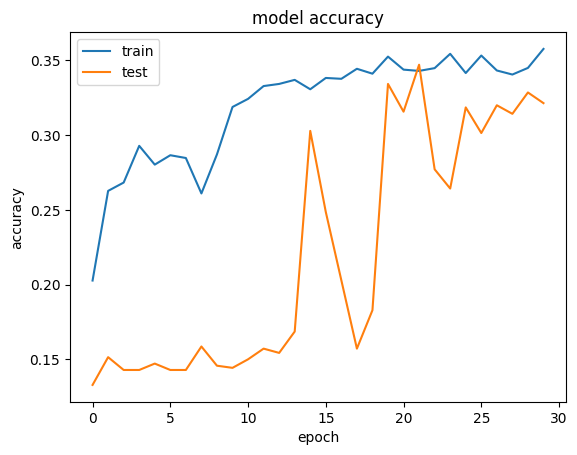

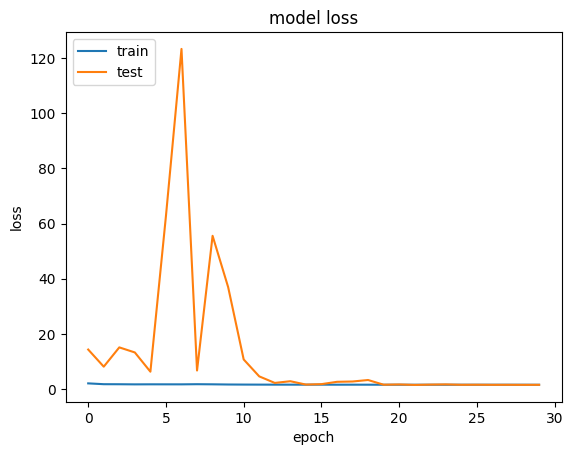

In [22]:
loss_accuracy_graph(train_history_resnet.history)

**Report and Confusion matrix**

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 747ms/step


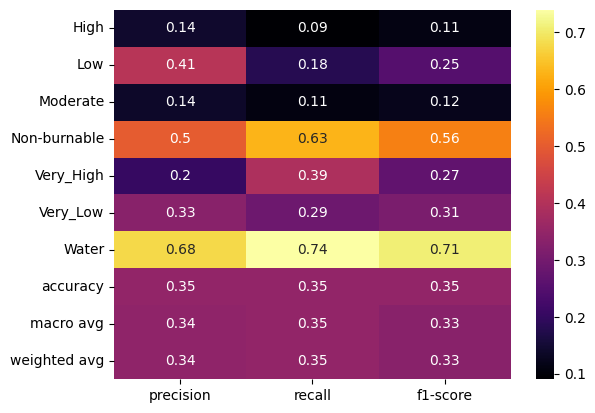

In [25]:
y_pred_resnet = model_resnet.predict(validation_generator)
y_pred_resnet = np.argmax(y_pred_resnet,axis=1)



y_test = validation_generator.classes



#classification report

report_test(y_test, y_pred_resnet)

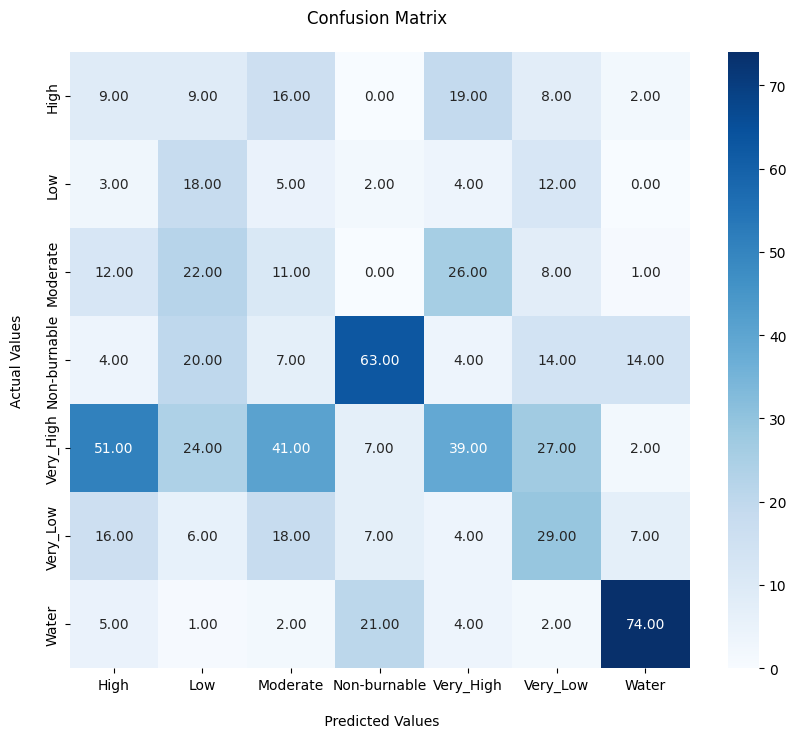

In [28]:
#confusion matrix

confusion_matrix_visual(y_pred_resnet, y_test)